In [3]:
import pandas as pd
import bs4
from bs4 import BeautifulSoup  
import csv
import numpy as np
import matplotlib.pyplot as plt      
from datetime import datetime
from datetime import timedelta
import sklearn
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import matplotlib.pyplot as plt  
import numpy as np
import seaborn as sns


In [4]:
### LinearRegression()
def load_dataset(df, label_column):
    y = df[label_column]
    X = df.drop(label_column, axis=1)
    return X, y


def data_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    return X_train, X_test, y_train, y_test

def normalize_data(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled

def train_model(X_train_scaled, y_train):
    reg = LinearRegression(normalize=True,fit_intercept= True)
    reg.fit(X_train_scaled, y_train)
    return reg

def predict_model(X_test_scaled,y_test , reg):
    y_pred = reg.predict(X_test_scaled)
    # create a dataframe with the results
    result = pd.DataFrame({'Actual': y_test, 'Predicted':  np.round(y_pred)})
 
    return y_pred, result


def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2

def tune_model(X_train_scaled, y_train):
    params = {'fit_intercept': [True, False], 'normalize': [True, False]}
    grid_search_cv = GridSearchCV(LinearRegression(), params, n_jobs=-1, verbose=1, cv=5)
    grid_search_cv.fit(X_train_scaled, y_train)
    best_params = grid_search_cv.best_params_
    best_score = grid_search_cv.best_score_
    return best_params, best_score

def return_best_model(X_train_scaled, X_test_scaled, y_train, y_test, best_params):
    reg = LinearRegression(**best_params)
    reg.fit(X_train_scaled, y_train)
    y_pred = reg.predict(X_test_scaled)
    return reg, y_pred

def remove_outliers(df):
    for col in df.select_dtypes(include=['float64','int']).columns:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

def drop_non_numeric_and_na_cols(df):
    # Get the list of non-numeric columns
    df = df.dropna(subset=['Long','Lat','Rooms','Floor','Floors']).reset_index(drop=True)
    non_numeric_cols = list(df.select_dtypes(exclude=['number']).columns)
    
    # Get the list of columns that contain NaNs
    na_cols = list(df.columns[df.isna().any()])
    
    # Combine the two lists and drop the columns from the DataFrame
    cols_to_drop = list(set(non_numeric_cols) | set(na_cols))
    df = df.drop(cols_to_drop, axis=1)
    df = remove_outliers(df)
    return df

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'fit_intercept': True, 'normalize': True}
Best Score: 0.1805530126484465
MAE: 658755.3430853356
R2: 0.5106477487478214


,Rooms,Floor,Size,Price,Build_year,Floors,Gush,Helka,Tat,Home_number,Long,Lat,Distance_sea,Year,AVG_ROOM_SIZE
0,4.0,1,108,2350000,1970,8.0,6630,234,3,13,181262.55,669790.75,1575,2009,27.0
1,4.0,3,100,265000,1935,4.0,6915,25,12,44,178329.82,664370.23,515,2009,25.0
2,4.0,1,76,1242000,1970,8.0,6631,165,98,28,181400.28,670121.86,1601,2009,19.0
3,2.5,2,42,300000,1970,3.0,7050,170,10,25,176787.25,659914.06,467,2009,16.8
4,2.0,2,52,1340000,1970,3.0,6953,30,13,5,179374.62,665694.23,1085,2009,26.0


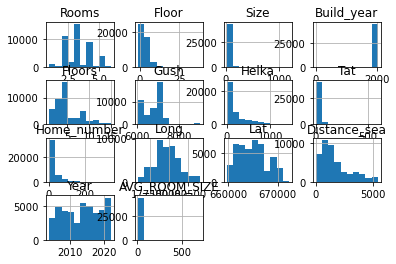

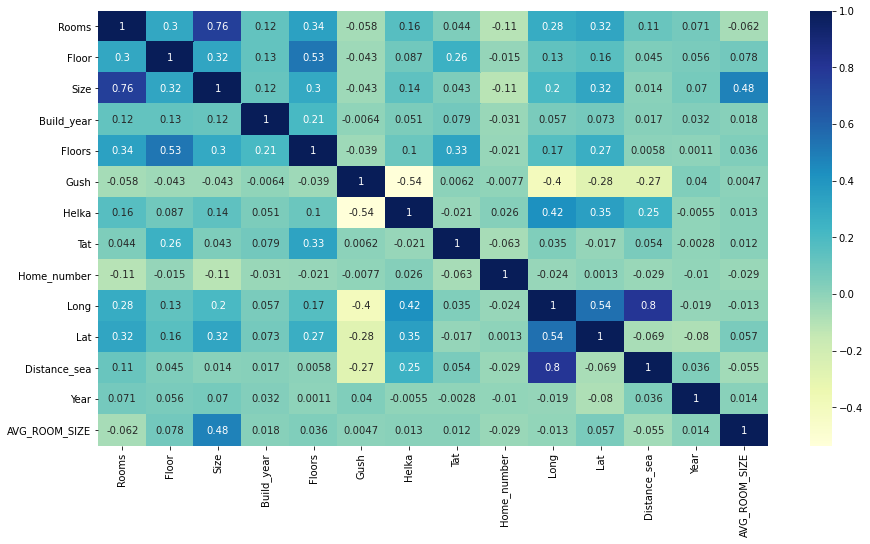

In [9]:
# df = pd.read_csv("Data/Real_Estate_TLV_Numric_Data.csv",index_col=0)
# df.drop(['NEIGHBORHOOD'],axis =1 , inplace =True)
# df = df[df['DATE'] >= 2019]
# df.drop(['AVG_SALARY'],axis =1 , inplace =True)

#Feature Engineering
# df['AVG_ROOM_SIZE'] = (df["ASSETMETER"] * df['ROOMNUM']).round(1)
# df['Slaray_sea_Raio'] = (df['AVG_SALARY'] * df['Distance_From_Sea']) / 1000
df = pd.read_csv("../Data/Nadlan_clean.csv",index_col=0)

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df['Year'] = df['Date'].dt.strftime('%Y')
df['Year'] = df['Year'].astype(int)
df = drop_non_numeric_and_na_cols(df)

df = df[df['Year'] < 2023]
df = df[df['Year'] > 2003]

df['AVG_ROOM_SIZE'] = (df["Size"] / df['Rooms']).round(1)




label_column = "Price"
X , y = load_dataset(df,label_column)
X_train, X_test, y_train, y_test = data_split(X, y)


#2. Normalize Data
X_train_scaled, X_test_scaled = normalize_data(X_train, X_test)

#3. Train Model
reg = train_model(X_train, y_train)

# #4. Predict Model
y_pred , model = predict_model(X_test,y_test, reg)



#5. Evaluate Model
mae, r2 = evaluate_model(y_test, y_pred)

#6. Tune Model
best_params, best_score = tune_model(X_train_scaled, y_train)

#7. Return Best Model
reg, y_pred = return_best_model(X_train_scaled, X_test_scaled, y_train, y_test, best_params)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("MAE:", mae)
print("R2:", r2)

X_train.hist()
plt.figure(figsize=(15,8))
sns.heatmap(X_train.corr(), annot =True ,cmap ='YlGnBu')
df.head()

In [ ]:
def rename_yad2_df(df):
    df.rename(columns={'price':'DEALAMOUNT'}, inplace=True)
    df.rename(columns={'neighborhood':'NEIGHBORHOOD'}, inplace=True)
    df.rename(columns={'buildingMR':'ASSETMETER'}, inplace=True)
    df.rename(columns={'TotalFloors':'BUILDINGFLOORS'}, inplace=True)
    df.rename(columns={'floor':'FLOOR'}, inplace=True)
    df.rename(columns={'buildyear':'BUILDINGYEAR'}, inplace=True)
    df.rename(columns={'year':'DATE'}, inplace=True)
    df.rename(columns={'rooms':'ROOMNUM'}, inplace=True)
#     df = df.reindex(columns=["DATE", "DEALAMOUNT", "BUILDINGYEAR", "BUILDINGYEAR", "BUILDINGFLOORS",
#                               "NEIGHBORHOOD", "ROOMNUM", "FLOOR", "ASSETMETER", "long", "lat", "Distance_From_Sea"])
    return df

def preprocess_dataframe(df):
    df = df.dropna()
    df = df.drop_duplicates()
    df.drop(['parking', 'balconies','shelter','on_pillars','storeroom','asset_classification','elevator','home_number'], axis=1 , inplace=True )
#     df['AVG_ROOM_SIZE'] = (df["buildingMR"] / df['rooms']).round(1)
    df = rename_yad2_df(df)
    
    df['BUILDINGFLOORS'] = df['BUILDINGFLOORS'].astype(int)

    
    
    # Remove columns with only one unique value
#     unique_counts = df.nunique()
#     cols_to_drop = unique_counts[unique_counts == 1].index
#     df = df.drop(cols_to_drop, axis=1)

    # Remove outliers
    for col in df.select_dtypes(include=['float64','int']).columns:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df


def recommend_affordable_apartments(df, model):
    X, y = load_dataset(df, "DEALAMOUNT")
    
    # We dont need the the second params so we will call it '_'
    X_scaled, _ = normalize_data(X, X)
    
    
    # Predict prices using the trained model
    y_pred = model.predict(X_scaled)
    df["PREDICTED_PRICE"] = y_pred
    df["PREDICTED_PRICE"] = df["PREDICTED_PRICE"].astype(int)
    df['difference'] =  df["DEALAMOUNT"] -  df["PREDICTED_PRICE"] 
    
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f'r2_score: {r2} , mae: {mae}')

    return df.sort_values(by="difference")

yad2_df = pd.read_csv("../Data/Real_Estate_TLV_YAD2_Numeric.csv",index_col=0)
# yad2_df.drop(['neighborhood'],axis =1 , inplace =True)
# yad2_df =yad2_df.dropna()
# yad2_df['year'] = 2022
yad2_df = preprocess_dataframe(yad2_df)

yad2_df = yad2_df.reindex(columns=["DATE", "DEALAMOUNT", "BUILDINGYEAR", "BUILDINGFLOORS",
                              "NEIGHBORHOOD", "ROOMNUM", "FLOOR", "ASSETMETER", "long", "lat", "Distance_From_Sea"])
yad2_df = yad2_df[np.isfinite(yad2_df["ASSETMETER"] / yad2_df['ROOMNUM'])]
yad2_df['AVG_ROOM_SIZE'] = (yad2_df["ASSETMETER"] / yad2_df['ROOMNUM']).round(1)
yad2_df['AVG_ROOM_SIZE'] = yad2_df['AVG_ROOM_SIZE'].astype(int)

# yad2_df = yad2_df.replace([np.inf, -np.inf], np.nan)
yad2_df

In [ ]:
affordable_deals = recommend_affordable_apartments(yad2_df, reg)
affordable_deals

In [ ]:
affordable_deals.sort_values(by="difference" , ascending=True )

affordable_deals = affordable_deals.reindex(columns=["DATE", "DEALAMOUNT",'PREDICTED_PRICE','difference', "BUILDINGYEAR", "BUILDINGFLOORS",
                               "ROOMNUM", "FLOOR", "ASSETMETER", "long", "lat", "Distance_From_Sea"])
#NEIGHBORHOOD
affordable_deals[10:70]